In [ ]:
from google.colab import drive
drive.mount("/content/drive")

PROJECT_ROOT = "/content/drive/MyDrive/stress-heart-ml-wesad"


In [ ]:
import os

PROJECT_ROOT = "/content/stress-heart-ml-wesad"
DATA_DIR = f"{PROJECT_ROOT}/data/processed"
RESULTS_DIR = f"{PROJECT_ROOT}/results"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Project directories ready ✅")


In [1]:
import kagglehub

path = kagglehub.dataset_download("mohamedasem318/wesad-full-dataset")

print("Path to dataset files:", path)


100%|██████████| 2.43G/2.43G [01:21<00:00, 32.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2


In [2]:
import os

root = "/root/.cache/kagglehub/datasets"

for path, dirs, files in os.walk(root):
    print(path)
    break


/root/.cache/kagglehub/datasets


In [3]:
import os

root = "/root/.cache/kagglehub/datasets"

for path, dirs, files in os.walk(root):
    print("DIR:", dirs)
    break


DIR: ['mohamedasem318']


In [4]:
import os

root = "/root/.cache/kagglehub/datasets"

for path, dirs, files in os.walk(root):
    if any(f.endswith(".pkl") for f in files):
        print("FOUND:", path)
        print("FILES:", files)
        break


FOUND: /root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S13
FILES: ['S13_readme.txt', 'S13.pkl', 'S13_quest.csv', 'S13_respiban.txt']


In [5]:
import pickle
import os

base = "/root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S13"

path = os.path.join(base, "S13.pkl")

with open(path, "rb") as f:
    data = pickle.load(f, encoding="latin1")

data.keys()


dict_keys(['signal', 'label', 'subject'])

In [6]:
signals = data['signal']['wrist']

eda = signals['EDA']

print("EDA Shape:", eda.shape)


EDA Shape: (22148, 1)


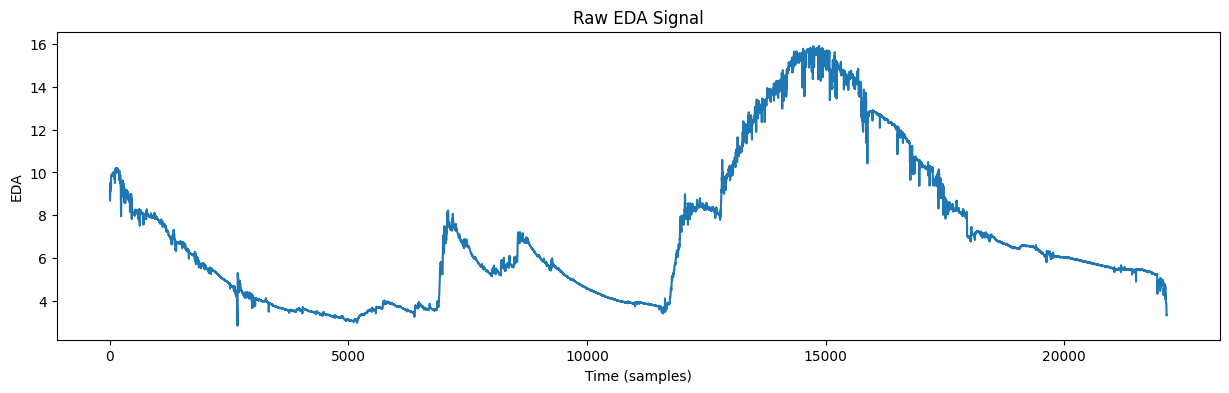

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(eda)
plt.title("Raw EDA Signal")
plt.xlabel("Time (samples)")
plt.ylabel("EDA")
plt.show()


Prepared EDA shape: (22148,) dtype: float64


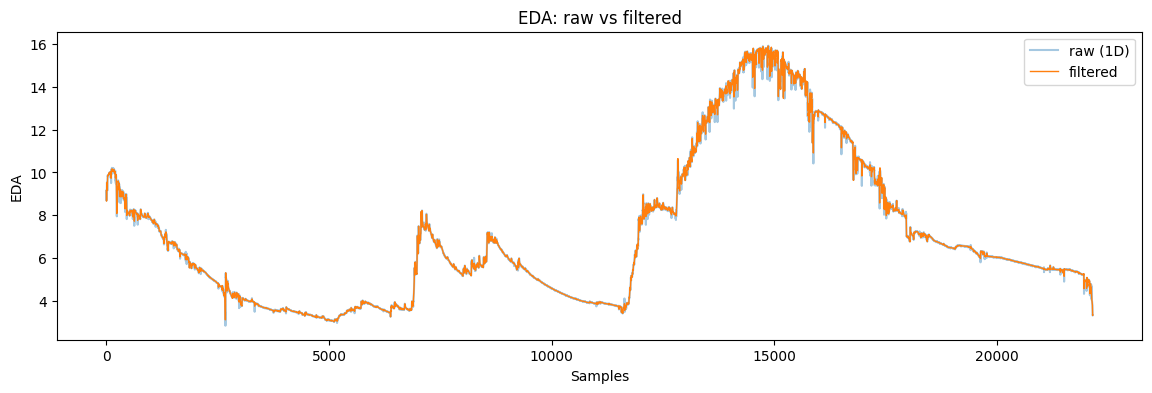

In [8]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

eda_raw = eda

# Convert to 1D
eda_1d = np.asarray(eda_raw).squeeze()

if eda_1d.ndim == 0:
    eda_1d = np.atleast_1d(eda_1d)

mask_bad = ~np.isfinite(eda_1d)
if mask_bad.any():
    idx = np.arange(eda_1d.size)
    good = ~mask_bad
    if good.sum() < 2:
        raise ValueError("Too many NaNs/infs in EDA to interpolate.")
    eda_1d = np.interp(idx, idx[good], eda_1d[good])

eda_1d = eda_1d.astype('float64')

print("Prepared EDA shape:", eda_1d.shape, "dtype:", eda_1d.dtype)
def butter_lowpass_filter_safe(x, cutoff=0.5, fs=4, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    padlen = 3 * max(len(a), len(b))
    if len(x) <= padlen:
        win = min(5, max(1, len(x)//5))
        return np.convolve(x, np.ones(win)/win, mode='same')

    try:
        y = filtfilt(b, a, x)
        return y
    except Exception as e:
        print("filtfilt failed, falling back to moving average. Error:", str(e))
        win = min(5, max(1, len(x)//5))
        return np.convolve(x, np.ones(win)/win, mode='same')
eda_filtered = butter_lowpass_filter_safe(eda_1d, cutoff=0.5, fs=4, order=4)
plt.figure(figsize=(14,4))
plt.plot(eda_1d, alpha=0.4, label='raw (1D)')
plt.plot(eda_filtered, linewidth=1, label='filtered')
plt.legend()
plt.title("EDA: raw vs filtered")
plt.xlabel("Samples")
plt.ylabel("EDA")
plt.show()


In [ ]:
eda

array([[9.149161],
       [8.816556],
       [8.713039],
       ...,
       [3.317144],
       [3.317144],
       [3.331215]])

In [9]:
from scipy.signal import find_peaks
import numpy as np

# EDA should be filtered first -> using eda_filtered
# normalize for easier peak detection
eda_norm = (eda_filtered - eda_filtered.min()) / (eda_filtered.max() - eda_filtered.min())

# detect peaks: height and distance prevent false spikes
peaks, properties = find_peaks(eda_norm, height=0.1, distance=10)

print("Number of SCR Peaks:", len(peaks))


Number of SCR Peaks: 854


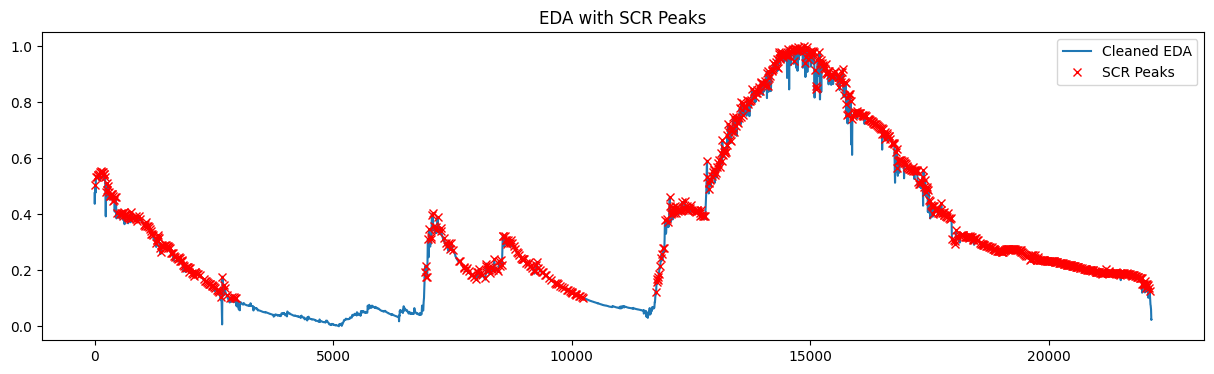

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(eda_norm, label="Cleaned EDA")
plt.plot(peaks, eda_norm[peaks], "rx", label="SCR Peaks")
plt.title("EDA with SCR Peaks")
plt.legend()
plt.show()


In [11]:
peak_heights = properties["peak_heights"]

scr_features = {
    "scr_peak_count": len(peaks),
    "scr_mean_amplitude": np.mean(peak_heights) if len(peak_heights) > 0 else 0,
    "scr_max_amplitude": np.max(peak_heights) if len(peak_heights) > 0 else 0,
}
scr_features


{'scr_peak_count': 854,
 'scr_mean_amplitude': np.float64(0.42712945047165585),
 'scr_max_amplitude': np.float64(1.0)}

In [12]:
from scipy.signal import savgol_filter
tonic = savgol_filter(eda_filtered, window_length=301, polyorder=3)
phasic = eda_filtered - tonic


In [13]:
eda_slope = np.gradient(eda_filtered)

eda_features = {
    "tonic_mean": np.mean(tonic),
    "phasic_std": np.std(phasic),
    "eda_slope_mean": np.mean(eda_slope),
    "eda_slope_std": np.std(eda_slope),
}

eda_features


{'tonic_mean': np.float64(7.093806438206945),
 'phasic_std': np.float64(0.16274049500806637),
 'eda_slope_mean': np.float64(-0.0002670165544716842),
 'eda_slope_std': np.float64(0.03486517001013166)}

In [14]:
signals = data['signal']['wrist']
bvp = signals['BVP']          # shape (n,1)
fs_bvp = 64                   # BVP sampling rate (Hz)

print(bvp.shape)


(354368, 1)


In [15]:
import numpy as np

bvp_1d = np.asarray(bvp).squeeze().astype(float)

# handle NaNs if any
mask = np.isfinite(bvp_1d)
bvp_1d = np.interp(
    np.arange(len(bvp_1d)),
    np.where(mask)[0],
    bvp_1d[mask]
)


In [16]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut=0.67, highcut=3.5, fs=64, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

bvp_filt = bandpass_filter(bvp_1d)


In [17]:
# time between beats (seconds)
rr_intervals = np.diff(peaks) / fs_bvp

# heart rate (BPM)
hr = 60 / rr_intervals

print("HR sample:", hr[:10])


HR sample: [166.95652174 213.33333333 384.         295.38461538 274.28571429
 160.         349.09090909 174.54545455 182.85714286 213.33333333]


In [18]:
# Time-domain HRV
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals)

hrv_features = {
    "SDNN": sdnn,
    "RMSSD": rmssd,
    "pNN50": pnn50
}

hrv_features


{'SDNN': np.float64(2.2590119748506843),
 'RMSSD': np.float64(3.2000515750077843),
 'pNN50': np.float64(0.6799531066822978)}

In [19]:
import numpy as np

def sliding_windows(signal, fs, window_sec=60, step_sec=30):
    win = int(window_sec * fs)
    step = int(step_sec * fs)
    windows = []
    for start in range(0, len(signal) - win, step):
        windows.append(signal[start:start + win])
    return windows


In [20]:
eda_windows = sliding_windows(eda_filtered, fs=4)
print("EDA windows:", len(eda_windows))


EDA windows: 183


In [21]:
from scipy.signal import find_peaks

def eda_stress_score(eda_win):
    eda_norm = (eda_win - eda_win.min()) / (eda_win.max() - eda_win.min() + 1e-8)
    peaks, _ = find_peaks(eda_norm, height=0.1, distance=5)
    return len(peaks), np.mean(eda_norm[peaks]) if len(peaks)>0 else 0


In [22]:
def hrv_from_bvp(bvp_win, fs=64):
    peaks, _ = find_peaks(bvp_win, distance=fs*0.4, prominence=0.2)
    if len(peaks) < 3:
        return None

    rr = np.diff(peaks) / fs

    return {
        "RMSSD": np.sqrt(np.mean(np.diff(rr)**2)),
        "SDNN": np.std(rr),
        "mean_HR": np.mean(60/rr)
    }


In [23]:
bvp_windows = sliding_windows(bvp_filt, fs=64)


In [24]:
dataset = []

for eda_w, bvp_w in zip(eda_windows, bvp_windows):
    scr_count, scr_amp = eda_stress_score(eda_w)
    hrv = hrv_from_bvp(bvp_w)

    if hrv is None:
        continue

    row = {
        "SCR_count": scr_count,
        "SCR_amp": scr_amp,
        "RMSSD": hrv["RMSSD"],
        "SDNN": hrv["SDNN"],
        "mean_HR": hrv["mean_HR"]
    }
    dataset.append(row)

import pandas as pd
df = pd.DataFrame(dataset)
df.head()


,SCR_count,SCR_amp,RMSSD,SDNN,mean_HR
0,19,0.911918,0.259355,0.183638,89.508652
1,20,0.754201,0.279629,0.200652,88.799274
2,19,0.670464,0.285574,0.203751,85.229163
3,14,0.535069,0.261767,0.182397,85.798746
4,16,0.802253,0.310516,0.202780,88.978919


In [25]:
df.describe()


,SCR_count,SCR_amp,RMSSD,SDNN,mean_HR
count,183.000000,183.000000,183.000000,183.000000,183.000000
mean,13.961749,0.609846,0.202098,0.154281,86.615970
std,4.204088,0.129049,0.063689,0.040166,6.283404
min,4.000000,0.280578,0.027330,0.034201,73.179644
25%,11.000000,0.528288,0.168083,0.127547,83.470287
50%,15.000000,0.603112,0.213891,0.155601,86.238488
75%,17.000000,0.694064,0.246579,0.181635,89.669654
max,22.000000,0.911918,0.332643,0.241022,107.628141


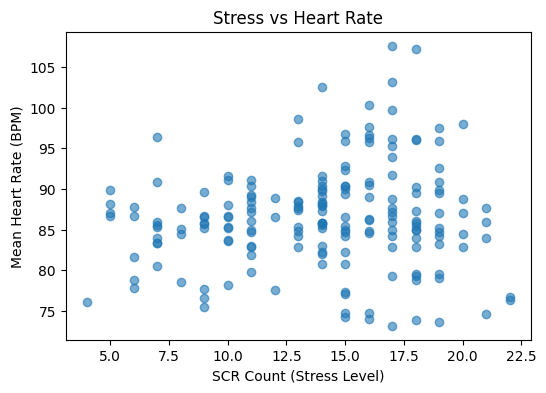

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(df["SCR_count"], df["mean_HR"], alpha=0.6)
plt.xlabel("SCR Count (Stress Level)")
plt.ylabel("Mean Heart Rate (BPM)")
plt.title("Stress vs Heart Rate")
plt.show()


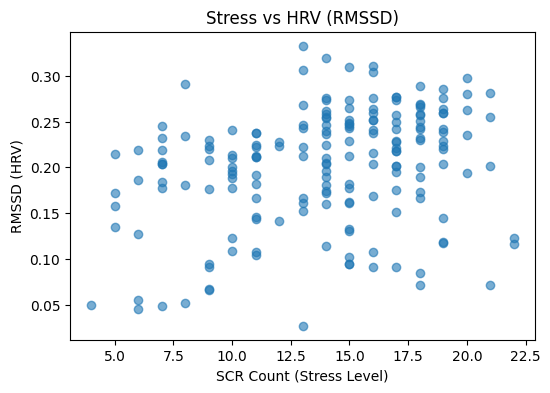

In [27]:
plt.figure(figsize=(6,4))
plt.scatter(df["SCR_count"], df["RMSSD"], alpha=0.6)
plt.xlabel("SCR Count (Stress Level)")
plt.ylabel("RMSSD (HRV)")
plt.title("Stress vs HRV (RMSSD)")
plt.show()


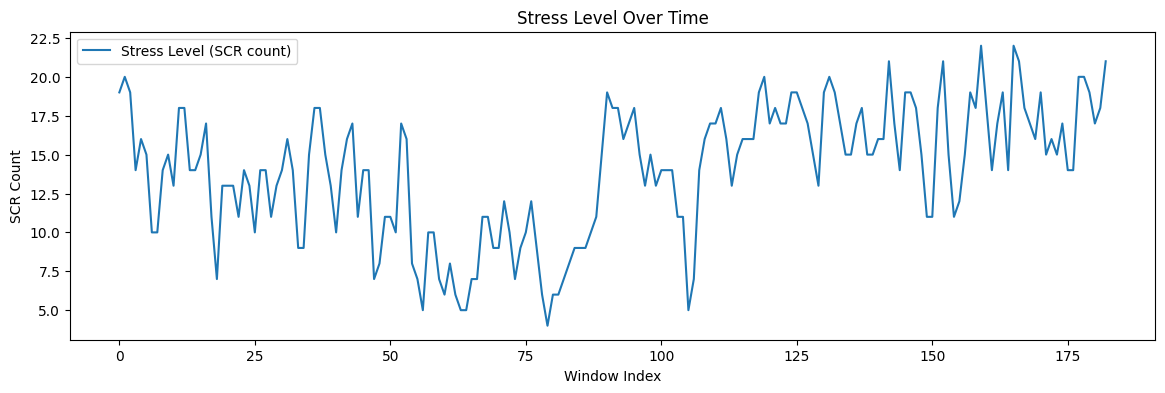

In [28]:
plt.figure(figsize=(14,4))
plt.plot(df["SCR_count"], label="Stress Level (SCR count)")
plt.xlabel("Window Index")
plt.ylabel("SCR Count")
plt.title("Stress Level Over Time")
plt.legend()
plt.show()


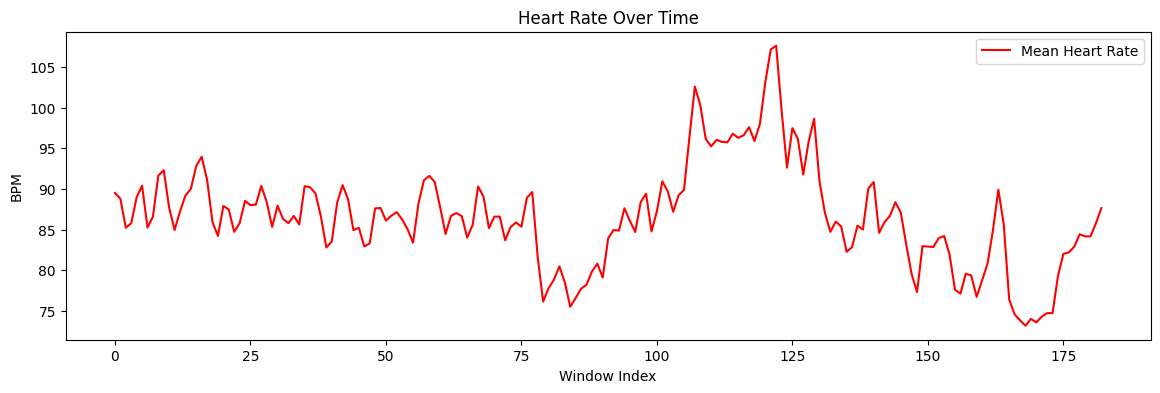

In [29]:
plt.figure(figsize=(14,4))
plt.plot(df["mean_HR"], color='r', label="Mean Heart Rate")
plt.xlabel("Window Index")
plt.ylabel("BPM")
plt.title("Heart Rate Over Time")
plt.legend()
plt.show()


In [30]:
labels = data['label']  # shape (N,)

def window_labels(labels, fs_label=700, window_sec=60, step_sec=30):
    win = int(window_sec * fs_label)
    step = int(step_sec * fs_label)
    y = []
    for start in range(0, len(labels) - win, step):
        window = labels[start:start+win]
        # majority vote
        y.append(np.bincount(window).argmax())
    return y


In [31]:
y = window_labels(labels)


In [32]:
min_len = min(len(df), len(y))
df_ml = df.iloc[:min_len].copy()
df_ml["label"] = y[:min_len]


In [33]:
label_map = {1:0, 2:1, 3:2}  # baseline, stress, amusement
df_ml["label"] = df_ml["label"].map(label_map)


In [34]:
df_ml.head()


,SCR_count,SCR_amp,RMSSD,SDNN,mean_HR,label
0,19,0.911918,0.259355,0.183638,89.508652,NaN
1,20,0.754201,0.279629,0.200652,88.799274,NaN
2,19,0.670464,0.285574,0.203751,85.229163,0.0
3,14,0.535069,0.261767,0.182397,85.798746,0.0
4,16,0.802253,0.310516,0.202780,88.978919,0.0


In [35]:
df_ml.to_csv("stress_heart_ml_dataset.csv", index=False)


In [41]:
df_ml_clean["label"].isna().sum()



np.int64(0)

In [39]:
df_ml_clean = df_ml.dropna(subset=["label"]).copy()


In [42]:
from sklearn.model_selection import train_test_split

X = df_ml_clean.drop(columns=["label"])
y = df_ml_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_preds = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_preds))
print("\nClassification Report:\n", classification_report(y_test, rf_preds))


Accuracy: 0.8666666666666667

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.80      1.00      0.89         4
         2.0       1.00      0.67      0.80         3

    accuracy                           0.87        15
   macro avg       0.89      0.85      0.85        15
weighted avg       0.88      0.87      0.86        15



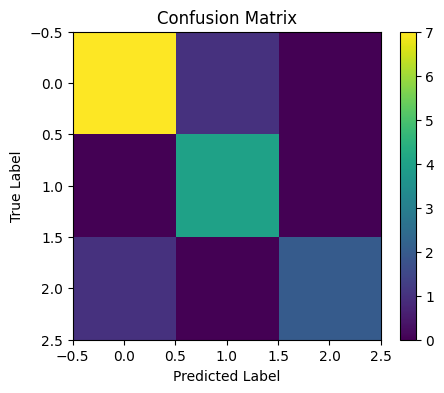

In [45]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


In [46]:
import pandas as pd

importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance


,0
mean_HR,0.410582
SCR_count,0.263804
SDNN,0.146770
RMSSD,0.095129
SCR_amp,0.083714


In [48]:
def build_subject_dataset(pkl_path, subject_id):
    """
    Takes a WESAD subject .pkl file
    Returns ML-ready dataframe for that subject
    """

    import pickle
    import numpy as np
    import pandas as pd
    from scipy.signal import butter, filtfilt, find_peaks

    # ------------------
    # Load data
    # ------------------
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    signals = data["signal"]["wrist"]
    labels  = data["label"]

    eda = signals["EDA"].squeeze()
    bvp = signals["BVP"].squeeze()

    # ------------------
    # EDA preprocessing
    # ------------------
    def lowpass(data, cutoff=0.5, fs=4, order=4):
        nyq = 0.5 * fs
        b, a = butter(order, cutoff/nyq, btype="low")
        return filtfilt(b, a, data)

    eda_f = lowpass(eda)

    # ------------------
    # BVP preprocessing
    # ------------------
    def bandpass(data, low=0.67, high=3.5, fs=64, order=3):
        nyq = 0.5 * fs
        b, a = butter(order, [low/nyq, high/nyq], btype="band")
        return filtfilt(b, a, data)

    bvp_f = bandpass(bvp)

    # ------------------
    # Windowing
    # ------------------
    def sliding_windows(x, fs, win=60, step=30):
        w = int(win * fs)
        s = int(step * fs)
        return [x[i:i+w] for i in range(0, len(x)-w, s)]

    eda_wins = sliding_windows(eda_f, fs=4)
    bvp_wins = sliding_windows(bvp_f, fs=64)

    # ------------------
    # Label windows
    # ------------------
    def window_labels(lbl, fs=700, win=60, step=30):
        w = int(win * fs)
        s = int(step * fs)
        y = []
        for i in range(0, len(lbl)-w, s):
            y.append(np.bincount(lbl[i:i+w]).argmax())
        return y

    y = window_labels(labels)

    # ------------------
    # Feature extraction
    # ------------------
    rows = []

    for e, b in zip(eda_wins, bvp_wins):
        # EDA features
        eda_n = (e - e.min()) / (e.max() - e.min() + 1e-8)
        peaks, _ = find_peaks(eda_n, height=0.1, distance=5)

        scr_count = len(peaks)
        scr_amp   = np.mean(eda_n[peaks]) if len(peaks) else 0

        # HRV features
        bp, _ = find_peaks(b, distance=64*0.4, prominence=0.2)
        if len(bp) < 3:
            continue

        rr = np.diff(bp) / 64

        rows.append({
            "mean_HR": np.mean(60/rr),
            "RMSSD": np.sqrt(np.mean(np.diff(rr)**2)),
            "SDNN": np.std(rr),
            "SCR_count": scr_count,
            "SCR_amp": scr_amp
        })

    df = pd.DataFrame(rows)

    # Align labels
    min_len = min(len(df), len(y))
    df = df.iloc[:min_len]
    df["label"] = y[:min_len]

    # Map labels + clean
    label_map = {1:0, 2:1, 3:2}
    df["label"] = df["label"].map(label_map)
    df = df.dropna().reset_index(drop=True)

    print(f"✅ Subject {subject_id}: {df.shape[0]} windows")

    return df


In [52]:
df_S2_ml = build_subject_dataset("/root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S2/S2.pkl", "S2")
df_S3_ml = build_subject_dataset("/root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S3/S3.pkl", "S3")


✅ Subject S2: 71 windows
✅ Subject S3: 73 windows


In [50]:
import os

BASE = "/root/.cache/kagglehub/datasets"

for root, dirs, files in os.walk(BASE):
    if "S2.pkl" in files:
        print("FOUND S2:", os.path.join(root, "S2.pkl"))
    if "S3.pkl" in files:
        print("FOUND S3:", os.path.join(root, "S3.pkl"))


FOUND S2: /root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S2/S2.pkl
FOUND S3: /root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S3/S3.pkl


In [53]:
X_train = df_S2_ml.drop(columns=["label"])
y_train = df_S2_ml["label"]

X_test  = df_S3_ml.drop(columns=["label"])
y_test  = df_S3_ml["label"]


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [56]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rf.predict(X_test_scaled)

print("Cross-subject Accuracy (S2 → S3):",
      accuracy_score(y_test, y_pred))

print("\nClassification Report:\n",
      classification_report(y_test, y_pred))


Cross-subject Accuracy (S2 → S3): 0.1506849315068493

Classification Report:
               precision    recall  f1-score   support

         0.0       0.19      0.08      0.11        38
         1.0       0.17      0.32      0.23        22
         2.0       0.06      0.08      0.07        13

    accuracy                           0.15        73
   macro avg       0.14      0.16      0.13        73
weighted avg       0.16      0.15      0.14        73



In [ ]:
import pandas as pd

df = pd.read_csv(f"{DATA_DIR}/stress_heart_ml_dataset.csv")
print("✅ Loaded ML dataset")
